## Chapter 7, ML Engineering
##### Author: Ben Wilson

In this notebook, we'll be following along with the code listings shown in Chapter 7 for the stand-alone (local VM) portion. This covers section 7.1, listings 7.1 through 7.3.<br>
For the remainder of the listing references in section 7.1, you can refer to the project notebook for the local VM implementation for hyperopt tuning of the forecasting problem in the companion notebook to this entitled, "Chapter7_Local_Hyperopt_Forecasting_Notebook". That notebook will serve as a full-implementation guide to the remainder of the code listings in section 7.1.

In [1]:
from matplotlib import pyplot as plt
import random
from hyperopt import hp, tpe, Trials, fmin

### Listing 7.1 Hyperopt fundamentals: the objective function
In these first 3 listings, we're going to take a look at what hyperopt is actually doing and how it's a bit different from other implementations of hyperparameter tuning. We'll be comparing how the other algorithms (Random Search and Grid Search) fare against hyperopt from an accuracy standpoint and see what comes of our results.<br>
To start off, we need a function to optimize. Listing 7.1 below is building a very simple 4th order polynomial that will, based on a value of x that is passed in, provide a loss metric in the form of a reduction factor to the 'y' value based on the submitted x. 

In [2]:
import numpy as np
def objective_function(x):
  func = np.poly1d([1, -3, -88, 112, -5])
  return func(x) * 0.01


For fun, let's see what this equation yields if we plot it in the space of [-100:100]

In [3]:
# Get a sorted list between -100 and 100 at every 0.1 increment
x_values_big = np.arange(-100, 100, 0.1)

# Get the y value for the x values defined above using list comprehension shorthand
y_values_big = [objective_function(x) for x in x_values_big]

# For those of you who prefer lambda calculus... (and more efficient execution)
y_values_lambda_big = (lambda x: objective_function(x))(x_values_big)

# Just to placate anyone who wonders if they do the same thing.
np.testing.assert_array_equal(np.array(y_values_big), y_values_lambda_big)

Ok, hold on... what's with the lambda stuff? Who wants functional programming concepts and partial functions in their code base for ML?<br><br>
Professional ML Engineers do.<br>
That is, when it's called for.<br>
<b><i>... and here's why.</i></b>

In [4]:
# let's make a few more x values here...
big_x_test = np.arange(-100, 100, 0.0001)

In [5]:
print("Let's make this many: {}".format(len(big_x_test)))

Let's make this many: 2000000


In [6]:
%time list_comp_test = [objective_function(x) for x in big_x_test]

CPU times: user 1min 18s, sys: 298 ms, total: 1min 18s
Wall time: 1min 18s


In [7]:
%time lambda_test = (lambda x: objective_function(x))(big_x_test)

CPU times: user 38.9 ms, sys: 33.8 ms, total: 72.7 ms
Wall time: 72.6 ms


That's... quite the difference. <br>
Feel free to play around with the value specified in the definition for <i>big_x_test</i> and see if you can melt your CPU and see the non-linear relationship in performance between a list comprehension and a lambda. <br>
Note: There are many times that a list comprehension will actually out-perform lambda tasks. But in this particular case, where we're effectively mapping over a collection and calling a function, the optimizations of how lambda handles the traversal with the numpy array (and the subsequent compiled C++ code at the heart of numpy) means that operating on the numpy array with a lambda is going to be MUCH faster than traversing a Python list with a comprehension. These differences only really come into play when you're doing large-scale operations such as this.

CPU times: user 434 ms, sys: 70.7 ms, total: 505 ms
Wall time: 502 ms


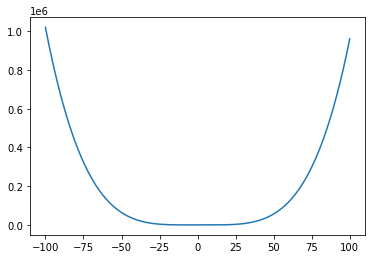

In [8]:
# Evaluate the wall-clock speed of plotting the list comprehension
%time plt.plot(big_x_test, list_comp_test)

CPU times: user 71 ms, sys: 44 ms, total: 115 ms
Wall time: 116 ms


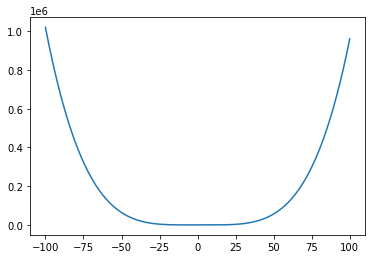

In [9]:
# And evaluate the wall-clock of plotting the lambda implementation
%time plt.plot(big_x_test, lambda_test)

.... and for those who will state, "But lambda and list comprehensions are lazily evaluated in Py3.x....", let's ensure that they're materialized through a forced execution by plotting their values in pyplot. This comes down the fact that one is a numpy array and one is a list (because the initial calculation to generate the collections above in the first block of timeit cells actually wasn't lazy).

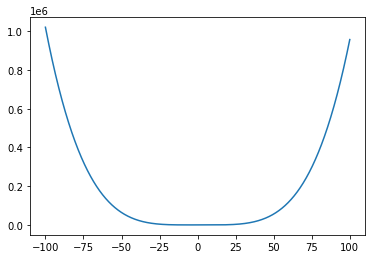

In [10]:
y_lambda = (lambda x: objective_function(x))(x_values_big)
plt.plot(x_values_big, y_lambda)

So... that's not super helpful for seeing the nuance to this equation. The resolution of the plot doesn't allow us to see where the actual minimum value is.

Let's see what the representation will be for this equation if we generate values against this function (in the x space before it becomes <b> very large in the y space</b> so that we can see the challenge that these different methods of searching for a global minima will have. This will help to inform our search range for the different approaches as well.

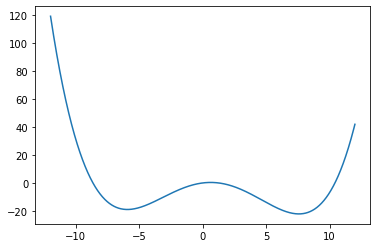

In [11]:
# Now, let's see it zoomed in to the range where we can see what's going on with minimum range of values for y...
x_axis_values = np.arange(-12.0, 12.0, 0.01).tolist()
y_values = (lambda x: objective_function(x))(x_axis_values)
plt.plot(x_axis_values, y_values)

Now, I know what you might be thinking... (it's what I'd be thinking if someone showed me this as well, likely...)<br>
"But Ben, dude, you can just get the minimum value directly from the data."<br>
To which I would reply...<br>
"Shhhh... I'm just trying to make a point here. Let's play pretend and think of this as a supervised learning problem where our vector has 17 dimensions and there's no way that our human minds can figure out how to minimize the function."<br>
But, to humor us both, here's the actual minimum x value.

In [12]:
x_axis_values[np.argmin(y_values)]

7.569999999999581

So, how would this look as a grid search problem?<br><br>
We would likely, when trying to do grid search over this space, select some collection of points to try, get the results, and then rank sort the return values, returning the lowest one. (Coincidentally that's exactly how grid search implementations actually work).

In [13]:
# our_grid = [-12, -11, -10, -9, -8.5, -8, ... ok, I'm not typing any more of this.]
our_grid = np.arange(-12, -8, 1).tolist() + np.arange(-8.5, 9.0, 0.5).tolist() + np.arange(9.0, 13, 1).tolist()
", ".join(str(g) for g in our_grid)

'-12, -11, -10, -9, -8.5, -8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 10.0, 11.0, 12.0'

Ok, so we have a grid to search over now. Let's see what the results of calling our function and getting a minima will be for this.

In [14]:
grid_search_test = (lambda x: objective_function(x))(our_grid)
print("Our minimum x value for our grid search is: {} based on a y min of {}".format(
    our_grid[np.argmin(grid_search_test)], grid_search_test.min()))

Our minimum x value for our grid search is: 7.5 based on a y min of -22.165625000000002


It was close. Definitely close. But is it close enough? Let's try a random search to see how that fares. <br>
We'll do the same exact search space (-12, 12) and give it 1000 iterations. 

(array([ 98.,  84., 107., 106., 103., 106., 112.,  95.,  97.,  92.]),
 array([-1.19695019e+01, -9.57358465e+00, -7.17766744e+00, -4.78175022e+00,
        -2.38583301e+00,  1.00842068e-02,  2.40600142e+00,  4.80191864e+00,
         7.19783585e+00,  9.59375307e+00,  1.19896703e+01]),
 <a list of 10 Patch objects>)

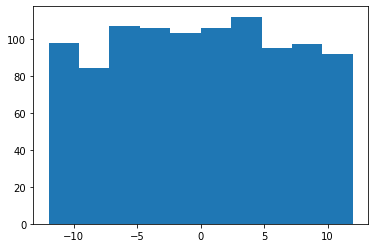

In [15]:
# We're going to use uniform search space here since that's how most people use the default values of a random search
# for hyperparameter tuning. (There are other options for most APIs though with different distributions)
random_search_x = [random.uniform(-12.0, 12.0) for x in range(1000)]
plt.hist(random_search_x)

And now, let's build the collection and see what happens for optimization.

In [16]:
random_search_test = (lambda x: objective_function(x))(random_search_x)
print("Our minimum x value for our random search is: {} based on a y min of {}".format(
    random_search_x[np.argmin(random_search_test)], random_search_test.min()))

Our minimum x value for our random search is: 7.559268444196029 based on a y min of -22.1750297705125


Wow, that was MUCH closer, right? <br>
It would take a bit longer than the grid search (particularly if we were doing something more complicated that basic linear algebra for our 'model') by searching through 1000 iterations.<br>
Let's see how many iterations it would take to get something VERY close to the global minima, though.
>> <b> NOTE: this algorithm for search space is non-deterministic. If you run this more than once, you're likely going to get different answers. That's how random number generators work.</b>

In [17]:
random_search_x_ridiculous = [random.uniform(-12.0, 12.0) for x in range(1000000)]
random_search_test_ridiculous = (lambda x: objective_function(x))(random_search_x_ridiculous)
print("Our minimum x value for our random search (ridiculous test) is: {} based on a y min of {}".format(
    random_search_x_ridiculous[np.argmin(random_search_test_ridiculous)], random_search_test_ridiculous.min()))

Our minimum x value for our random search (ridiculous test) is: 7.572346332547564 based on a y min of -22.175349266642858


Now that... that is impressive. We're VERY close to the actual confirmed global minima for this function.<br>

Let's see how hyperopt does, though...

### Listing 7.2 Hyperopt search space for a one-dimensional polynomial optimization pattern
This is the code listing from the book for this section (minus the import statement for hyperopt modules which is at the top of this notebook).

In [18]:
# To make it fair, we're going to use a uniform search space as well.
optimization_space = hp.uniform('x', -12, 12)

trials = Trials()

trial_estimator = fmin(fn=objective_function, 
                       space=optimization_space, 
                       algo=tpe.suggest,
                       trials=trials,
                       max_evals=1000                      
                      ) 

100%|██████████| 1000/1000 [00:09<00:00, 103.58trial/s, best loss: -22.175349000150717]


### Listing 7.3 Demonstration of hyperopt performance in minimizing a simple polynomial function
And here is where we are going to let hyperopt find the minima as best it can...

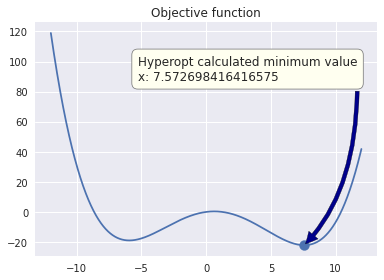

In [19]:
rng = np.arange(-12.0, 12.0, 0.01).tolist()
values = (lambda x: objective_function(x))(rng)
with plt.style.context(style='seaborn'):
    fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))
    ax.plot(rng, values)
    ax.set_title('Objective function')
    ax.scatter(x=trial_estimator['x'], y=trials.average_best_error(), marker='o', s=100)
    bbox_text = 'Hyperopt calculated minimum value\nx: {}'.format(trial_estimator['x'])
    arrow = dict(facecolor='darkblue', shrink=0.01, connectionstyle='angle3,angleA=90,angleB=45')
    bbox_conf = dict(boxstyle='round,pad=0.5', fc='ivory', ec='grey', lw=0.8)
    conf = dict(xycoords='data', textcoords='axes fraction', arrowprops=arrow, bbox=bbox_conf, ha='left', va='center', fontsize=12)
    ax.annotate(bbox_text, xy=(trial_estimator['x'], trials.average_best_error()), xytext=(0.3, 0.8), **conf)
    fig.tight_layout()
    plt.savefig('objective_func.png', format='png', dpi=1000)

In [20]:
ground_truth = x_axis_values[np.argmin(y_values)]
grid_search_error = np.abs(our_grid[np.argmin(grid_search_test)] - ground_truth)
random_search_error = np.abs(random_search_x[np.argmin(random_search_test)] - ground_truth)
random_search_ridiculous_error = np.abs(
    random_search_x_ridiculous[np.argmin(random_search_test_ridiculous)] - ground_truth)
hyperopt_error = np.abs(trial_estimator['x'] - ground_truth)

print("Grid Search absolute error: {}".format(grid_search_error))
print("Random Search absolute error: {}".format(random_search_error))
print("Random Search Ridiculous absolute error: {}".format(random_search_ridiculous_error))
print("Hyperopt absolute error: {}".format(hyperopt_error))

Grid Search absolute error: 0.06999999999958106
Random Search absolute error: 0.01073155580355234
Random Search Ridiculous absolute error: 0.00234633254798311
Hyperopt absolute error: 0.002698416416993865


I think we can safely agree that Grid search may not be the most optimal way to tune models. It's slow, inefficient, and requires many runs to 'fine tune' the search space to get something approximating a 'well tuned model'.<br>
The <i>interesting</i> results here are between hyperopt and random search.<br><br>
While the 'Ridiculous (1 million iterations)' Random Search optimization beat hyperopt, it did so by a relatively small margin. However, it did so through training <b><u>999,000 more calculations than hyperopt did</u></b>. Doesn't really seem like it would scale to your real-world supervised learning problem, does it?<br>
If we compare hyperopt to the results from the iterations-matched random search with the same exact search space using the same sampling distribution (uniform), hyperopt beat random search soundly.<br>
> This is why hyperopt was invented and why it's so very powerful. It gives fantastic results in far fewer iterations than other implementations that are widely used in the ML community.

>><b> NOTE: Since the Random Search and HyperOpt both are using sampling algorithms that rely on random float selection, even though from the same spaces, these algorithms are non-deterministic. Each time that you run them you will get different results from the optimization. However, with enough iterations over these runs, you will find that the general performance will hold true across these different implementations for finding the global mim